# under construction

**Goal:** 
...  

**Usage:**  
...  
**Dataset:** 
...  
**Content:**
* ...


| [open in colab](TODO_link)



In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


### Working with a TFP Normal distribution

In [20]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=[3], scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution 

tf.Tensor(
[[3.9847302]
 [2.3804226]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.21440445]
 [0.24421422]], shape=(2, 1), dtype=float32)


#### Imports

### Simulate the fishlike data

In the next few cells you will simulate some data that looks like a fish.You will fist simulate random distributed noise with non constant varaiance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y= 2.7*x+noise (linear slope of 2.7 and intercept of 0) . The variance of the noise will change, it starts with high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. Let's sample random distributed noise with that variance. 

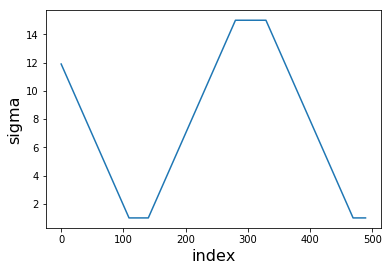

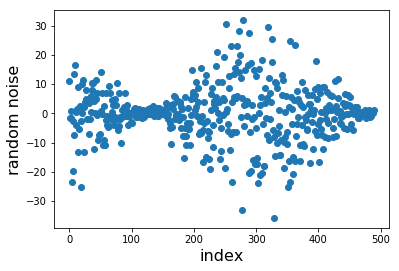

In [4]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()

np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
#plot the noise that you add to a linear regression
plt.scatter(np.arange(0,len(noise),1),noise)
plt.xlabel("index",size=16)
plt.ylabel("random noise",size=16)#pred
plt.show()


Now you will sample random uniformly distributed x values in the range from -1 to 6. you will sample less x values in the range from -1 to 1 which will be the first part of the random distributed variance where the noise is decrasing. The dataset will have more x values in the range from 1 to 6 than in the range from -1 to 1. You will generate as much x values as we have random noise points. Finally you want to sort the x values (for ploting reasons). 

In [5]:
# generation the x values for the simulated data
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data comple. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [6]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [7]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [9]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. It really looks a bit like a fish. In the following cells you will train diffrent models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model (lowest NLL on the validation dataset). It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction for it. That is the reason why you will plot it only in the end.

(-30, 55)

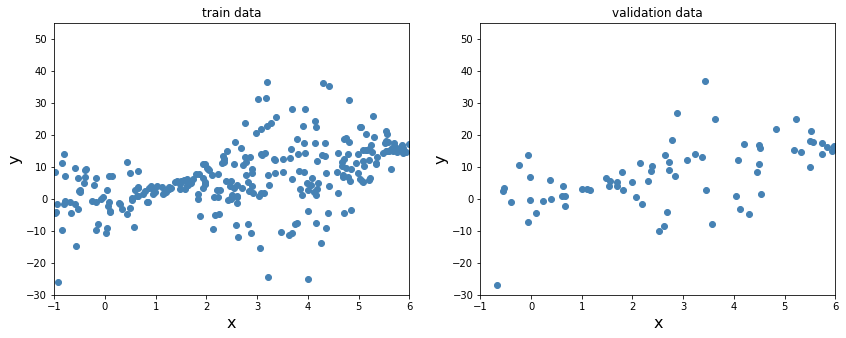

In [10]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1,6])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1,6])
plt.ylim([-30,55])

## Fit linear regression with constant variance (sigma =1)

In [16]:
# ### make this with tfp 
# ### try diffrent sigmas and look how it affects est mu (it does not)
# ### try diffrent sigmas and look how it affects correspondig NLL (it does)

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
# model.compile(loss='mse',                    #A
#          optimizer="adam", metrics=['accuracy'])

# ## A call the standard Keras loss MSE 
# ## hier muss man noch sigma schätzen (mean residuals durch (n-2)) (erklärung wäre noch gut)
# ## 
# model.summary()
# model.fit(x_train,y_train,batch_size=16,epochs=2000,verbose=0)

### Using TFP for linear regression with constant variance

In [52]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=10)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(learning_rate=0.01), loss=NLL) #E

#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Compiling the model with NLL as loss function

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_5 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [55]:
hist = model.fit(x, y, epochs=1000, verbose=0, validation_data=(x_val,y_val))

3.2517482004165648

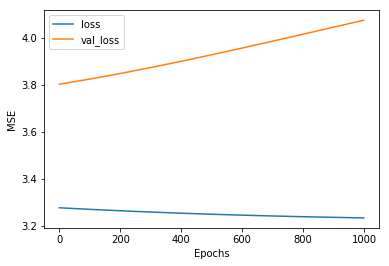

In [56]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

In [58]:
model_mean = Model(inputs=inputs, outputs=dist.mean())

(-25, 55)

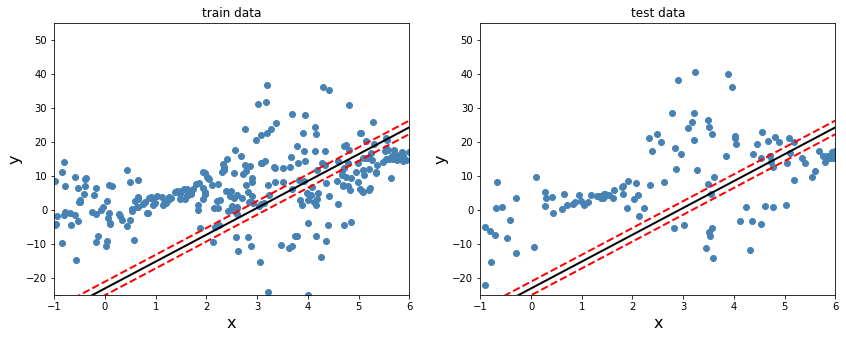

In [57]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds_tr = model_mean.predict(x_train)
sigma = 1
plt.plot(x_train,preds_tr,color="black",linewidth=2)
plt.plot(x_train,preds_tr+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_train,preds_tr-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1,6])
plt.ylim([-25,55])
#plt.savefig("fish_2.pdf")
#files.download("fish_2.pdf")

preds_te = model_mean.predict(x_test)
plt.subplot(1,2,2)
plt.scatter(x_test,y_test,color="steelblue") #observerd 
plt.plot(x_test,preds_te,color="black",linewidth=2)
plt.plot(x_test,preds_te+2,color="red",linestyle="--",linewidth=2)
plt.plot(x_test,preds_te-2,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1,6])
plt.ylim([-25,55])
#plt.xlabel("x",size=16)
#plt.ylabel("y",size=16)

## Fit linear regression allow the sd to depend in a monotonic way on the input

In [13]:
def NLL(y, distr):
  return -distr.log_prob(y) #A

In [0]:
# montonic sd change
model = tf.keras.Sequential() 
model.add(tf.keras.layers.Dense(2,input_shape=(1,))) #B
model.add(tfp.layers.DistributionLambda(  
        lambda t: tfd.Normal(loc=t[:,0:1], #C
        scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))) #D
model.compile(optimizer=tf.optimizers.Adam(), loss=NLL) 



In [407]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_11 (Dist ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [408]:
model.fit(x_train, y_train, epochs=1000, verbose=0)

(-25, 55)

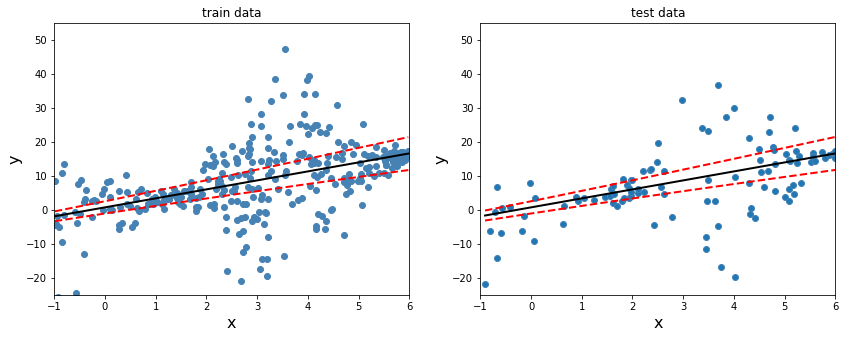

In [409]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
plt.plot(x_train,model(x_train).mean(),color="black",linewidth=2)
plt.plot(x_train,model(x_train).mean()+2*model(x_train).stddev(),color="red",linestyle="--",linewidth=2)
plt.plot(x_train,model(x_train).mean()-2*model(x_train).stddev(),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1,6])
plt.ylim([-25,55])
#plt.savefig("fish_3.pdf")
#files.download("fish_3.pdf")

# test data
plt.subplot(1,2,2)
plt.scatter(x_test,y_test,edgecolors="steelblue") #observerd 
plt.plot(x_test,model(x_test).mean(),color="black",linewidth=2)
plt.plot(x_test,model(x_test).mean()+2*model(x_test).stddev(),color="red",linestyle="--",linewidth=2)
plt.plot(x_test,model(x_test).mean()-2*model(x_test).stddev(),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1,6])
plt.ylim([-25,55])
#plt.savefig("fish_3.pdf")
#files.download("fish_3.pdf")

In [0]:
## cal NLL for train and vaild

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

In [0]:
def NLL(y, rv_y):
  return -rv_y.log_prob(y) #A

In [0]:

inputs = Input(shape=(1,))
out1 = tf.keras.layers.Dense(1)(inputs)
hidden1 = tf.keras.layers.Dense(20,activation="relu")(inputs)
hidden2 = tf.keras.layers.Dense(10,activation="relu")(hidden1)
out2 = tf.keras.layers.Dense(1)(hidden2)
out = tf.keras.layers.Concatenate()([out1,out2])
predictions = tfp.layers.DistributionLambda(lambda t: 
     tfd.Normal(loc=t[:, 0:1],
     scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(out)
model2 = Model(inputs=inputs, outputs=predictions)
model2.compile(optimizer=tf.optimizers.Adam(), loss=NLL)


In [414]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 20)           40          input_5[0][0]                    
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 10)           210         dense_32[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 1)            2           input_5[0][0]                    
____________________________________________________________________________________________

In [415]:
model2.fit(x_train,y_train,epochs=2000,verbose=0)


In [416]:
model2.evaluate(x,y)#should be around 3.1
#if not train longer

424/424 [==============================] - 0s 131us/sample - loss: 3.2006


3.2005614087266743

In [0]:
#x_val = np.linspace(-1,6,50)
#x_val = x_val.reshape((50,1))
#x_val.shape, x.shape

In [0]:
# for extrapolation
#x_val = np.linspace(-5,10,50)
#x_val = x_val.reshape((50,1))
#x_val.shape, x.shape

(-25, 55)

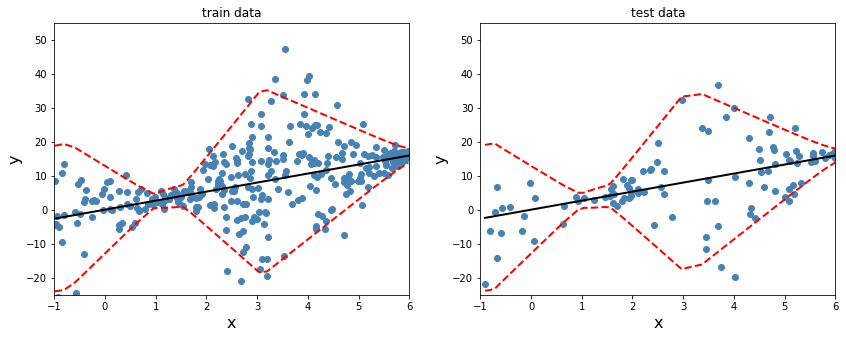

In [419]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
plt.plot(x_train,model2(x_train).mean(),color="black",linewidth=2)
plt.plot(x_train,model2(x_train).mean()+2*model2(x_train).stddev(),color="red",linestyle="--",linewidth=2)
plt.plot(x_train,model2(x_train).mean()-2*model2(x_train).stddev(),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1,6])
plt.ylim([-25,55])

plt.subplot(1,2,2)
plt.scatter(x_test,y_test,color="steelblue") #observerd 
plt.plot(x_test,model2(x_test).mean(),color="black",linewidth=2)
plt.plot(x_test,model2(x_test).mean()+2*model2(x_test).stddev(),color="red",linestyle="--",linewidth=2)
plt.plot(x_test,model2(x_test).mean()-2*model2(x_test).stddev(),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1,6])
plt.ylim([-25,55])

In [0]:
#plt.scatter(x,y,color="steelblue") #observerd 
#plt.plot(x_val,model2(x_val).mean(),color="black",linewidth=2)
#plt.plot(x_val,model2(x_val).mean()+2*model2(x_val).stddev(),color="red",linestyle="--",linewidth=2)
#plt.plot(x_val,model2(x_val).mean()-2*model2(x_val).stddev(),color="red",linestyle="--",linewidth=2)
#plt.xlabel("x",size=16)
#plt.ylabel("y",size=16)
##plt.savefig("fish_4.pdf")
##files.download("fish_4.pdf")

In [421]:
np.mean(-(model2(x_test).log_prob(x_test)))


6.088601

In [422]:
-(model2(x_test).log_prob(x_test))

<tf.Tensor: id=3339012, shape=(106, 1), dtype=float32, numpy=
array([[ 3.3007395],
       [ 3.300598 ],
       [ 3.2923105],
       [ 3.2733333],
       [ 3.2642708],
       [ 3.2196755],
       [ 3.2100198],
       [ 3.1057737],
       [ 2.9324882],
       [ 2.8984208],
       [ 2.803821 ],
       [ 2.736008 ],
       [ 2.7028193],
       [ 2.027822 ],
       [ 1.9856331],
       [ 1.8310608],
       [ 1.9165871],
       [ 2.2924786],
       [ 2.4447098],
       [ 2.6451836],
       [ 2.601871 ],
       [ 2.5677388],
       [ 2.4978137],
       [ 2.4893844],
       [ 2.4786258],
       [ 2.472188 ],
       [ 2.5432684],
       [ 2.5540338],
       [ 2.5863101],
       [ 2.6506681],
       [ 2.680287 ],
       [ 2.688603 ],
       [ 2.73339  ],
       [ 2.7348537],
       [ 2.735879 ],
       [ 2.7535758],
       [ 2.8759985],
       [ 2.8852954],
       [ 2.9696834],
       [ 2.986626 ],
       [ 3.094193 ],
       [ 3.1129007],
       [ 3.1631048],
       [ 3.2064912],
       [ 3.219

In [423]:
-np.log(model2(x_test).prob(x_test))

array([[ 3.3007395],
       [ 3.300598 ],
       [ 3.2923105],
       [ 3.2733333],
       [ 3.2642708],
       [ 3.2196755],
       [ 3.2100198],
       [ 3.1057737],
       [ 2.9324882],
       [ 2.8984208],
       [ 2.803821 ],
       [ 2.736008 ],
       [ 2.7028193],
       [ 2.027822 ],
       [ 1.9856331],
       [ 1.8310608],
       [ 1.9165871],
       [ 2.2924786],
       [ 2.4447098],
       [ 2.6451836],
       [ 2.601871 ],
       [ 2.5677388],
       [ 2.4978137],
       [ 2.4893844],
       [ 2.4786258],
       [ 2.472188 ],
       [ 2.5432684],
       [ 2.5540338],
       [ 2.5863101],
       [ 2.6506681],
       [ 2.680287 ],
       [ 2.688603 ],
       [ 2.73339  ],
       [ 2.7348537],
       [ 2.735879 ],
       [ 2.7535758],
       [ 2.8759985],
       [ 2.8852954],
       [ 2.9696834],
       [ 2.986626 ],
       [ 3.094193 ],
       [ 3.1129007],
       [ 3.1631048],
       [ 3.2064912],
       [ 3.2198248],
       [ 3.2765326],
       [ 3.3098357],
       [ 3.31

In [427]:
model2.evaluate(x_train,y_train)

318/318 [==============================] - 0s 47us/sample - loss: 3.2206


3.2205637798369304

In [428]:
### so ist es richtig!!!
np.mean(-model2(x_train).log_prob(y_train))

3.220564

In [429]:
np.mean(-model2(x_test).log_prob(y_test))

3.1405542

In [0]:
### extraploation und erlaube für x 

In [0]:
### test daten zu verfügung stellen und das denn Nll ausrechnen als aufgabe des besten model


In [0]:
### aufgabe für sinus, spliting selber, netz vorgen, hidden dazu oder nicht? 
### fragen wie man das am besten modelieren soll